# Demonstration of XAFS Scans and Energy Scans

This notebook shows the following tasks:

- [running a basic single-segment XANES scan](#Running-a-Single-Segment-XANES-scan)
- [load and plot a dataset](#Loading-the-Data)
- [running a multi-segment XAFS scan](#Running-a-Multi-Segment-XAFS-Scan)
- [running a multi-segment EXAFS scan using k-space](#Running-a-Multi-Segment-EXAFS-Scan-in-K-space)
- [modifying the list of detectors](#Modifying-the-List-of-Detectors)

First we have to **import haven**, the beamline control library. Haven contains most of the tools we will use. Importing it allows us to get to the functions and classes that are defined inside.

Next, the ``haven.load_instrument()`` function will read the configuration files and scan the hardware for its configuration. It will then **build the devices** that will be used for scans. This function prints out a list of motors that it has discovered.

Then, we create the run engine. The run engine is responsible for executing our scans and will be described in more detail when it is used below.

Lastly we set metadata about who is running the beamline. This value will be saved in every plan executing on this run engine. This step is optional, but will allow database queries for scans taken by a specific person.

In [2]:
import haven

# Import some things to allow for live plotting
from bluesky.callbacks.mpl_plotting import LivePlot
from bluesky.utils import install_nb_kicker
install_nb_kicker()

# Load the motors and detectors
haven.load_instrument()
# The RunEngine will be responsible for executing the plans
RE = haven.RunEngine()
# (Optional) Save the initials of the current beamline operator as metadata
RE.md["operator"] = "MFW"  # <- Put your initials in here

sim_motor
sim_detector
energy_energy
energy_mono_energy
Ipreslit_sensitivity_sens_level
Ipreslit
IpreKB_sensitivity_sens_level
IpreKB
I0_sensitivity_sens_level
I0
It_sensitivity_sens_level
It
SLT V Upper
SLT V Lower
SLT H Inb
SLT H Outb
KBH Down
KBH Up
KBV Down
KBV Up
KB Tbl H
KB Tbl V
Focus V
Focus H
Focus In Out
huberRot
ADC KB Focus
SampleZ(KBH Down)
I0 H
I0 V
Optic In Out
Optic V
Optic H
motor 25test
Tbl H Cdn
Tbl Up Cdn
Tbl Down Cdn
JJSlitUp Cdn
JJSlitDn Cdn
JJSlitInB Cdn
JJSlitOutB Cdn
H Down Trans Cdn
H Up Trans Cdn
H Down Bend Cdn
H Up Bend Cdn
V Down Bend Cdn
V Up Bend Cdn
V Down Trans Cdn
V Up Trans Cdn
ORM1 height
ORM1 roll
ORM1 upstream lateral
ORM1 downstream lateral
ORM2 height
ORM2 roll
ORM2 upstream lateral
ORM2 downstream lateral
ORM2 bender
Upstream horizontal
Upstream diagonal
Upstream pitch
Upstream yaw
Downstream horizontal
Downstream diagonal
Downstream pitch
Downstream yaw
A-Hutch BPM
monochromator_energy
monochromator_offset
monochromator_horiz
monochromator_ver

## Running a Single-Segment XANES scan

Running a scan in bluesky is a **two step process**.

First, **create a plan**. A plan generates messages with instructions to do things like move a motor, wait for a motor to arrive at its destination, and trigger and read a detector. To create a plan, you call a function that will generate these messages. **Calling the function doesn't actually execute the scan.** In our case, ``haven.xafs_scan(8325, 0.5, 1, 8350)`` will create the plan, but the plan will not do anything unless used with a run engine.

The `haven.xafs_scan()` plan requires at least four values: *(start, step, exposure, stop)*. *start* and *stop* mark the boundaries of the energy range, in eV. *step* is the space between energy points, in eV. Unless the range between *start* and *stop* is a whole multiple of *step*, the *stop* energy will not appear in the scan. *exposure* is the time, in seconds, for which to count at each energy.

The optional argument *E0* specifies the energy, in eV, of an x-ray absorbance edge. If given, all other energy values (i.e. *start* and *stop*) will be relative to *E0*. 

Next, **execute the plan on the run engine**. At the top of this document we created a run engine. Now we will use this run engine to execute the plan. The run engine will read the messages and perform the appropriate tasks.

When the run engine finishes the plan, it will return a unique identifier (UID). This UID is the best way to retrieve the data from the database. We will save the UID to a variable, and also print it to the page in case we want to recall it later.

In [ ]:
# These two plans will scan from 8323 eV to 8383 eV
#   in 2eV steps with 1 sec exposure
absolute_plan = haven.xafs_scan(8323, 2, 1, 8383)
relative_plan = haven.xafs_scan(-20, 2, 1, 50, E0=8333)
# Run one of the plans with the previously created RunEngine
uid = RE(relative_plan)
print(uid)

## Loading the Data

During execution the data are saved to a mongoDB database. Haven has tools to retrieve the data.

The ``load_data()`` function will return a data set, provided we supply the uid that we had previously recorded. It is possible to have multiple experimental runs within a single call to the run engine, and so our variable *uid* from above is actually a list of UIDs. Since there was only one run, we will just use the first (and only) entry: ``uid[0]``.

If the analysis is being done at a different time or place from running the scan, then the variable *uid* will probably not be set. In this case, it is possible to provide the UID that was printed above.

Optionally, the **data can be saved to a text CSV file** for additional analysis. First we will convert it to a pandas DataFrame and then use panda's ``to_csv()`` method. We will append the first segment of the UID to the filename to descrease the likelihood that we will overwrite data.

In [ ]:
# Uncomment this line to manually specify a UID
# uid = ["927fa7dd-e331-45ca-bb9d-3f89d7c65b17"]
# Load the data for the first (and only) UID in the list
data = haven.load_data(uid[0])
# Save the data to a CSV file, with tabs ("\t") instead of commas.
data.to_pandas().to_csv(f"xafs_scan_example_{uid[0].split('-')[0]}.csv", sep='\t')
# Plot the result
data["od"] = data["It_raw_counts"] / data["I0_raw_counts"]
plt.plot(data['energy'], data['od'])

## Running a Multi-Segment XAFS Scan

The ``xafs_scan()`` function can accept multiple sets of values to accomodate additional scan regions. After the first set of four parameters (*start*, *step*, *exposure*, *stop*), additional sets of three parameters (*step*, *exposure*, *stop*) can be given and will use the previous *stop* energy as its new *start* energy.

Additionally, Haven will look up the literature energy for a given X-ray absorption edge, in this case the Ni K-edge.

The call below will scan the following energies, relative to 8333 eV:

- -50 to -10 eV (8283 to 8323 eV) in 5 eV steps with 0.5 sec exposure
- -10 to +50 eV (8323 to 8383 eV) in 1 eV steps with 1 sec exposure
- +50 to +200 eV (8383 to 8533 eV) in 10 eV steps with 0.5 sec exposure

In [ ]:
multisegment_plan = haven.xafs_scan(-50, 5, 0.5,  # start, step, exposure
                                    -10, 1, 1,  # start, step, exposure
                                    50, 10, 0.5,  # start, step, exposure
                                    200,  # stop
                                    E0="Ni_K")
# Run one of the plans with the previously created RunEngine
uid = RE(multisegment_plan)
print(uid)

## Running a Multi-Segment EXAFS Scan in K-space

The `xafs_scan()` function can also accept one energy segment as X-ray wavenumbers instead of X-ray energy using the *k_step*, *k_exposure* and *k_max* keyword-only parameters. *k_weight* controls the increasing exposure time at higher wavenumbers.

/home/beams0/S25IDCUSER/src/haven/haven/plans/energy_scan.py:129: UserWarning: Offset for undulator gap not corrected in energy_scan
  warnings.warn(msg)
Offset for undulator gap not corrected in energy_scan


('256a8c24-593e-4eb4-9390-2b7748b60b61',)


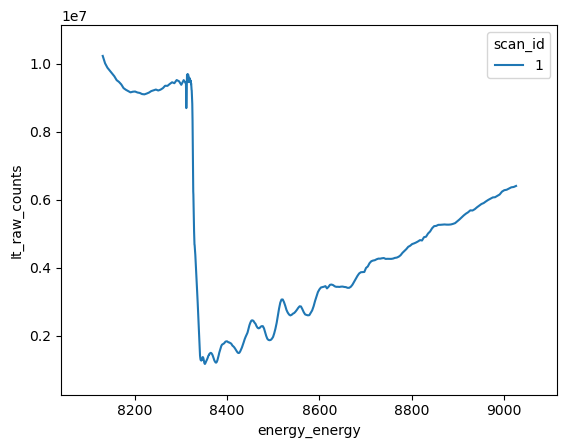

In [3]:
exafs_plan = haven.xafs_scan(-200, 5, 1.0,  # start, step, exposure
                             -20, .3, 1,  # start, step, exposure
                             30,  # Last non-k energy point (also start of k-region in eV)
                             k_step=0.05, k_exposure=1.0, k_max=13.5, k_weight=0.5,
                             E0=8331.0)
# Run the plan with the previously created RunEngine
uid = RE(exafs_plan, LivePlot('It_raw_counts', 'energy_energy'))
print(uid)

## Modifying the List of Detectors

By default, ``xafs_scan()`` measures all registered ion chambers, most likely those set up during `haven.load_instrument()` called above. This default list can be overridden by using the *detectors* argument. This example records only those scaler channels whose EPICS records' `.DESC` values are "It", "I0", or "Iref". Modify these names to suit your use case.

In [ ]:
detectors_plan = haven.xafs_scan(8323, 2, 1, 8383, detectors=["It", "I0", "Iref"])
# Run the plan with the previously created RunEngine
uid = RE(detectors_plan)
print(uid)